# 1. Importing Libraries

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

# 2. Loading Datasets

In [45]:
fear = pd.read_csv("fear_greed_index.csv")
historical = pd.read_csv("historical_data.csv")

print("fear_greed_dataset Columns:", fear.columns)
print("historical_dataset Columns:", historical.columns)
print(fear.head())
print(historical.head())

fear_greed_dataset Columns: Index(['timestamp', 'value', 'classification', 'date'], dtype='object')
historical_dataset Columns: Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')
    timestamp  value classification        date
0  1517463000     30           Fear  2018-02-01
1  1517549400     15   Extreme Fear  2018-02-02
2  1517635800     40           Fear  2018-02-03
3  1517722200     24   Extreme Fear  2018-02-04
4  1517808600     11   Extreme Fear  2018-02-05
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c19

# 3. Preprocessing Sentiment Data

In [46]:
sentiment_df = pd.read_csv('fear_greed_index.csv')

# Converting UNIX timestamp to datetime and extracting date for later merging
sentiment_df['datetime'] = pd.to_datetime(sentiment_df['timestamp'], unit='s')
sentiment_df['date'] = sentiment_df['datetime'].dt.date

# Mapping sentiment categories to numerical scores
sentiment_map = {
    'Extreme Fear': 0,
    'Fear': 1,
    'Neutral': 2,
    'Greed': 3,
    'Extreme Greed': 4
}
sentiment_df['sentiment_score'] = sentiment_df['classification'].map(sentiment_map)

# Aggregating daily average sentiment values
daily_sentiment = sentiment_df.groupby('date').agg({
    'value': 'mean',
    'sentiment_score': 'mean'
}).reset_index()

print("Processed Sentiment Data:")
print(daily_sentiment.head())


Processed Sentiment Data:
         date  value  sentiment_score
0  2018-02-01   30.0              1.0
1  2018-02-02   15.0              0.0
2  2018-02-03   40.0              1.0
3  2018-02-04   24.0              0.0
4  2018-02-05   11.0              0.0


# 4. Preprocessing Trader Data

In [47]:
trades_df = pd.read_csv('historical_data.csv')

# Parsing 'Timestamp IST' and converting to UTC timezone
trades_df['timestamp'] = pd.to_datetime(
    trades_df['Timestamp IST'],
    dayfirst=True
).dt.tz_localize('Asia/Kolkata').dt.tz_convert('UTC')

# Filtering trades related to BTC or @107
btc_trades = trades_df[trades_df['Coin'].str.contains('BTC|@107', case=False, regex=True)]

# Aggregating daily metrics
daily_trades = btc_trades.groupby(pd.Grouper(key='timestamp', freq='D')).agg({
    'Size USD': 'sum',
    'Execution Price': 'mean',
    'Closed PnL': 'sum',
    'Trade ID': 'count'
}).rename(columns={
    'Size USD': 'total_volume_usd',
    'Execution Price': 'avg_execution_price',
    'Closed PnL': 'net_pnl',
    'Trade ID': 'trade_count'
}).reset_index()

# Extracting date for merging
daily_trades['date'] = daily_trades['timestamp'].dt.date

print("\nProcessed Trader Data:")
print(daily_trades.head())



Processed Trader Data:
                  timestamp  total_volume_usd  avg_execution_price  net_pnl  \
0 2023-12-04 00:00:00+00:00          24998.62              41866.5      0.0   
1 2023-12-05 00:00:00+00:00              0.00                  NaN      0.0   
2 2023-12-06 00:00:00+00:00              0.00                  NaN      0.0   
3 2023-12-07 00:00:00+00:00              0.00                  NaN      0.0   
4 2023-12-08 00:00:00+00:00              0.00                  NaN      0.0   

   trade_count        date  
0            2  2023-12-04  
1            0  2023-12-05  
2            0  2023-12-06  
3            0  2023-12-07  
4            0  2023-12-08  


# 5. Merging Sentiment & Trader Data

In [48]:
# Merging datasets on date
merged_df = pd.merge(daily_sentiment, daily_trades, on='date', how='inner')

# Filtering out days with zero trades
merged_df = pd.merge(daily_sentiment, daily_trades[daily_trades['trade_count'] > 0], on='date', how='inner')

print("Filtered Merged Data Shape:", merged_df.shape)
print("Merged Data Summary:")
print(merged_df.describe())

# Checking sentiment distribution
print("\nSentiment Counts:")
print(merged_df['sentiment_score'].value_counts())

# Mapping numerical score back to sentiment label
sentiment_labels = {
    0: 'Extreme Fear',
    1: 'Fear',
    2: 'Neutral',
    3: 'Greed',
    4: 'Extreme Greed'
}
merged_df['classification'] = merged_df['sentiment_score'].map(sentiment_labels)
print(merged_df[['sentiment_score', 'classification']].head())


Filtered Merged Data Shape: (289, 8)
Merged Data Summary:
            value  sentiment_score  total_volume_usd  avg_execution_price  \
count  289.000000       289.000000      2.890000e+02           289.000000   
mean    58.854671         2.553633      2.422121e+06         51032.604212   
std     19.007664         1.159829      6.513329e+06         25817.905314   
min     10.000000         0.000000      2.260000e+01            17.981780   
25%     46.000000         2.000000      1.205854e+05         37366.032524   
50%     64.000000         3.000000      4.278770e+05         56486.000000   
75%     74.000000         3.000000      1.675442e+06         69150.444444   
max     94.000000         4.000000      4.751704e+07         98429.275862   

             net_pnl  trade_count  
count     289.000000   289.000000  
mean    12636.531667   193.965398  
std     49366.633719   309.611885  
min    -48061.993170     1.000000  
25%         0.000000    10.000000  
50%       825.230544    59.00000

# 6. Exploratory Visualization

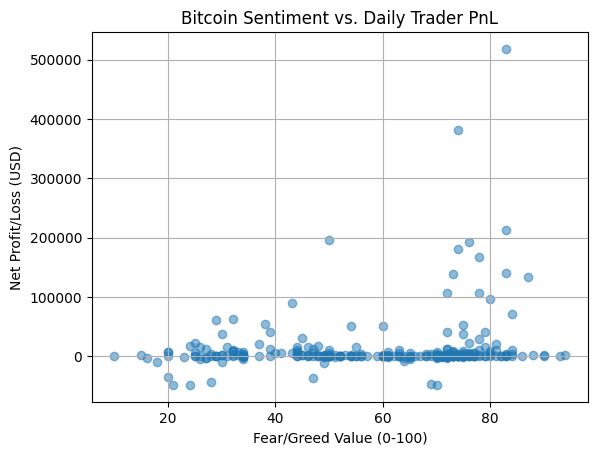

In [49]:
# Scatter plot: Sentiment Value vs Net PnL
plt.scatter(merged_df['value'], merged_df['net_pnl'], alpha=0.5)
plt.title("Bitcoin Sentiment vs. Daily Trader PnL")
plt.xlabel("Fear/Greed Value (0-100)")
plt.ylabel("Net Profit/Loss (USD)")
plt.grid()
plt.show()

# 7. Average PnL by Sentiment


Avg. PnL by Sentiment:
classification
Extreme Fear     -8789.727259
Neutral           6964.730793
Greed             8677.550810
Fear              9088.522866
Extreme Greed    30059.988840
Name: net_pnl, dtype: float64


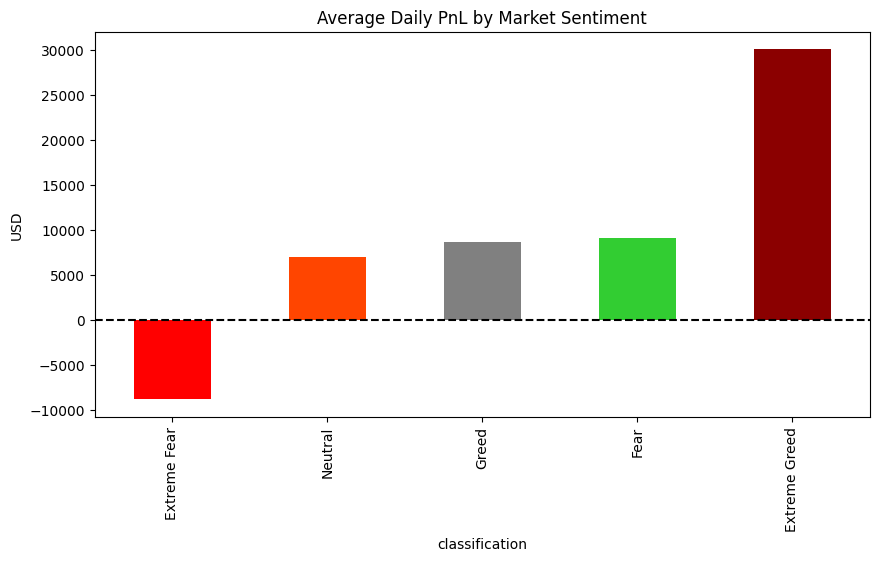

In [50]:
avg_pnl_by_sentiment = merged_df.groupby('classification')['net_pnl'].mean().sort_values()
print("\nAvg. PnL by Sentiment:")
print(avg_pnl_by_sentiment)

# Bar plot of Average PnL by Sentiment
avg_pnl_by_sentiment.sort_values().plot(
    kind='bar',
    color=['red', 'orangered', 'gray', 'limegreen', 'darkred'],
    figsize=(10, 5)
)
plt.title("Average Daily PnL by Market Sentiment")
plt.ylabel("USD")
plt.axhline(0, color='black', linestyle='--')
plt.show()

# 8. ANOVA Test for Statistical Significance

In [51]:
groups = [merged_df[merged_df['classification'] == sentiment]['net_pnl']
          for sentiment in avg_pnl_by_sentiment.index]
f_stat, p_value = f_oneway(*groups)

print(f"ANOVA p-value: {p_value:.4f}")
print("Statistically Significant?", p_value < 0.05)

ANOVA p-value: 0.0158
Statistically Significant? True
